In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web 
import re

### Get Stock Price

In [2]:
start = datetime.datetime(2017,3,1)
end = datetime.datetime(2017,4,28)
UAL = web.DataReader("UAL", "yahoo", start, end)

In [3]:
UAL_price=UAL.loc[:,['Open','Close']]
UAL_price['price']=list(map(lambda x,y: x-y, UAL_price.loc[:,'Open'], UAL_price.loc[:,'Close']))

In [4]:
UAL_price['trend']=1
i=[]
for i in np.arange(len(UAL_price.loc[:,'price'])):
    if UAL_price.iloc[i,2] > 0: 
        UAL_price.iloc[i,3]='up'
    elif UAL_price.iloc[i,2] == 0: 
        UAL_price.iloc[i,3]='-'
    else: 
        UAL_price.iloc[i,3]='dwon'
    i +=1

In [5]:
UAL_price.head()

,Open,Close,price,trend
Date,,,,
2017-03-01,74.639999,75.389999,-0.750000,dwon
2017-03-02,74.349998,73.279999,1.069999,up
2017-03-03,73.699997,75.589996,-1.889999,dwon
2017-03-06,74.849998,73.139999,1.709999,up
2017-03-07,72.690002,72.639999,0.050003,up


In [6]:
UAL_price.trend.value_counts()

dwon    22
up      20
Name: trend, dtype: int64

### Import Tweets

In [7]:
#import the tweets file
tweets_table_428 =  pd.read_csv(r'C://Users//amyhu//Google Drive//660//chromedriver_win32//tweets_try_ua_0428_formal.txt',encoding='utf-8', error_bad_lines=False,sep='\t',header=None)
tweets_table_420 =  pd.read_csv(r'C://Users//amyhu//Google Drive//660//chromedriver_win32//tweets_try_ua.txt',encoding='utf-8', error_bad_lines=False,sep='\t',header=None)

In [8]:
def dataclean(tweets_table):
    tweets_table=tweets_table.iloc[:,[0,2,4,6,8]]
    tweets_table=tweets_table.rename(columns={0:'tweets',2:'retweet',4:'favorites',6:'replies',8:'date'})
    
    g = lambda x: str(int(x))
    tweets_table=tweets_table.dropna(subset=['date'])
    tweets_table.replies = tweets_table.replies.fillna("0").apply(g)
    
    f = lambda x: float(x.replace("K",""))*1000 if "K" in x else int(x)
    tweets_table.retweet = tweets_table.retweet.fillna("0").apply(f)
    tweets_table.favorites = tweets_table.favorites.fillna("0").apply(f)
    tweets_table.replies = tweets_table.replies.fillna("0").apply(f)
    
    print(tweets_table.isnull().sum())
    return tweets_table

In [9]:
tweets_table_428 = dataclean(tweets_table_428)

tweets       0
retweet      0
favorites    0
replies      0
date         0
dtype: int64


In [10]:
tweets_table_420 = dataclean(tweets_table_420)

tweets       0
retweet      0
favorites    0
replies      0
date         0
dtype: int64


In [11]:
import codecs
#function that loads a lexicon of positive words to a set and returns the set
def loadLexicon(fname):
    newLex=set()
    lex_conn=codecs.open(fname, encoding='utf-8')
    #add every word in the file to the set
    for line in lex_conn:
        newLex.add(line.strip())# remember to strip to remove the lin-change character
    lex_conn.close()

    return newLex

In [12]:
def sentiment(line):
    #load the positive and negative lexicons
    posLex=loadLexicon('positive-words.txt')
    negLex=loadLexicon('negative-words.txt')
    

    posList=[] #list of positive words in the review
    negList=[] #list of negative words in the review
        
   
    line=line.lower().strip()     
        
    words=line.split(' ') # slit on the space to get list of words
   
    for word in words: #for every word in the review
        if word in posLex: # if the word is in the positive lexicon
                posList.append(word) #update the positive list for this review
        if word in negLex: # if the word is in the negative lexicon
                negList.append(word) #update the negative list for this review

        # 0 for neutral    
    if len(posList)>len(negList): # more pos words than neg
            decision='positive' # 1 for positiv
    elif len(negList)>len(posList):  # more neg than pos
            decision='negative' # -1 for negative
    else:
            decision = 'neutral'
        
    return decision 

In [13]:
#Apply sentiment function for all tweets
tweets_table_420['sentiment'] = list(map(sentiment,tweets_table_420['tweets']))
tweets_table_428['sentiment'] = list(map(sentiment,tweets_table_428['tweets']))


In [14]:
from dateutil.parser import parse
import datetime

In [15]:
def Date_Formate(tweets_table):
#Change the format of date
    tweets_table=tweets_table.reset_index()
    i=[]
    for i in np.arange(len(tweets_table.loc[:,'date'])):
        tweets_table.loc[i,'date']=datetime.datetime.strptime(str(tweets_table.loc[i,'date']).lstrip(), '%d %b %Y').strftime('%Y-%m-%d')
        i += 1
        
    #Remove the the tweets before 2017-03-01 which are not target data
    tweets_table=tweets_table[tweets_table['date']>='2017-03-01']
    #tweets_table=tweets_table[tweets_table['date']<'2017-04-20']
    tweets_table_1=tweets_table.set_index(['date'])
    
    tweets_table_1=tweets_table_1.rename({'2017-03-04':'2017-03-06','2017-03-05':'2017-03-06',
                        '2017-03-11':'2017-03-13','2017-03-12':'2017-03-13',
                       '2017-03-18':'2017-03-20','2017-03-19':'2017-03-20',
                       '2017-03-25':'2017-03-27','2017-03-26':'2017-03-27',
                      '2017-04-01':'2017-04-03','2017-04-02':'2017-04-03',
                      '2017-04-08':'2017-04-10','2017-04-09':'2017-04-10',
                      '2017-04-14':'2017-04-17','2017-04-15':'2017-04-17','2017-04-16':'2017-04-17',
                        '2017-04-22':'2017-04-24','2017-04-23':'2017-04-24'})
    
    #Join the table of tweets and stock price based on the date index
    result=tweets_table_1.join(UAL_price, how='outer')
    
    #Remove unnecessary 
    result_df=result.drop('index',1).drop('Open',1).drop('Close',1).drop('price',1).drop('tweets',1)
    result_df_1=result_df.dropna(subset=['sentiment'])
    
    print(result_df_1.isnull().sum())
    print(result.sentiment.value_counts())
    
    return result_df_1

In [16]:
result_df_420 = Date_Formate(tweets_table_420)

retweet      0
favorites    0
replies      0
sentiment    0
trend        0
dtype: int64
neutral     509
negative    367
positive    201
Name: sentiment, dtype: int64


In [17]:
result_df_428 = Date_Formate(tweets_table_428)

retweet      0
favorites    0
replies      0
sentiment    0
trend        0
dtype: int64
neutral     1834
negative    1287
positive     637
Name: sentiment, dtype: int64


### Modeling and Predicting

In [34]:
from sklearn import preprocessing
def encode_variable(result_df_1):
    label_encoder = preprocessing.LabelEncoder()
    result_df_1['sentiment'] = label_encoder.fit_transform(result_df_1['sentiment'])
    result_df_1['trend'] = label_encoder.fit_transform(result_df_1['trend'])
    return result_df_1

In [35]:
df_420 = encode_variable(result_df_420)

In [37]:
df_428 = encode_variable(result_df_428)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

C:\Users\amyhu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\amyhu\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [39]:
random_state = 367

In [40]:
def model_accarucy(x):
    train, test = train_test_split(x, train_size = 0.6)
    
    x_train = train.iloc[:,0:4]
    y_train = train.iloc[:,-1]
    
    x_test = test.iloc[:,0:4]
    y_test = test.iloc[:,-1]
    
    LREG_grid = [ {'C':[0.5,1,1.5,2],'penalty':['l1','l2']}]
    LREG_classifier=LogisticRegression()
    gridsearchLREG  = GridSearchCV(LREG_classifier, LREG_grid, cv=5)
    gridsearchLREG.fit(x_train,y_train)
    
    KNN_grid = [{'n_neighbors': [1,3,5,7,9,11,13,15,17], 'weights':['uniform','distance']}]
    KNN=KNeighborsClassifier()
    gridsearchKNN = GridSearchCV(KNN, KNN_grid, cv=5)
    gridsearchKNN.fit(x_train, y_train)
    
    RF_grid = [{'max_depth': [3,4,5,6,7,8,9,10,11,12],'criterion':['gini','entropy']}]
    RF = RandomForestClassifier(n_estimators=250, criterion='entropy',  n_jobs = -1,  random_state=random_state)
    gridsearchRF = GridSearchCV(RF, RF_grid, cv=5)
    gridsearchRF.fit(x_train, y_train)
    
    GBC_grid = [{'n_estimators':[1,2,3,4,5,6,7],'max_depth':[10,20,30,40,50], 'min_samples_split':[200,300,400,500]}]
    GBC = GradientBoostingClassifier()
    gridsearchGBC = GridSearchCV(GBC, GBC_grid, cv=5,scoring='roc_auc',n_jobs=4,iid=False,)
    gridsearchGBC.fit(x_train, y_train)
    
    XGB_grid = [{'max_depth':[10,20,30,40,50],'min_child_weight':[1,2,3,4,5,6,7]}]
    XGB = XGBClassifier(seed=random_state)
    gridsearchXGB = GridSearchCV(XGB, XGB_grid, cv=5)
    gridsearchXGB.fit(x_train, y_train)
    
    eclf_1 = VotingClassifier(estimators=[
    ('KNN', gridsearchKNN), ('RF', gridsearchRF), ('GBC', gridsearchGBC), ('XGB',gridsearchXGB),('LREG',gridsearchLREG)], voting='soft')   
    eclf_1.fit(x_train, y_train)
    y_pred_1 = eclf_1.predict(x_test)
    return accuracy_score(y_test,y_pred_1)

In [41]:
model_accarucy(df_420)

0.92343387470997684

In [42]:
model_accarucy(df_428)

0.51329787234042556

In [18]:
from os import path
from PIL import Image
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [89]:
def wordcloud(tweets_table):
    text=[]
    for i in tweets_table.tweets:
        text += [i]
        
    text = str(text).lower()
    
    text = re.sub('[^a-z]',' ',text)
    
    text = re.sub('united airlines',' ',text)
    
    text = re.sub('united airline',' ',text)
    
    text = re.sub('unitedairline',' ',text)
    
    text = re.sub('united',' ',text)
    
    text = re.sub('flight',' ',text)
    
    text = re.sub('airline',' ',text)
    
    return text

In [90]:
text_1 = wordcloud(tweets_table_420)
text_2 = wordcloud(tweets_table_428)

In [93]:
def wordscloud(text):
    d = path.dirname("C://Users//amyhu//Google Drive//660//chromedriver_win32")

    # read the mask image
    mask = np.array(Image.open(path.join(d, "C://Users//amyhu//Google Drive//660//chromedriver_win32//airplane_2.jpg")))

    stopwords = set(STOPWORDS)
    stopwords.add("said")

    wc = WordCloud(background_color="white", max_words=2000, mask=mask,
               stopwords=stopwords)

    # generate word cloud
    wc.generate(text)

    # store to file
    wc.to_file(path.join(d, "C://Users//amyhu//Google Drive//660//chromedriver_win32//UA_2.png"))

    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.figure()
    plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
    return plt.show()
    
    

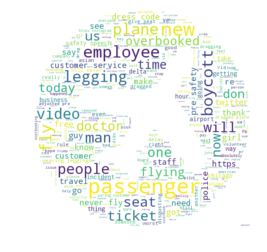

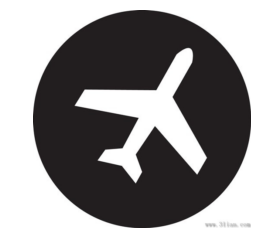

In [92]:
wordscloud(text_1)

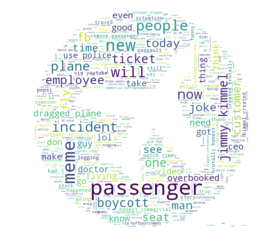

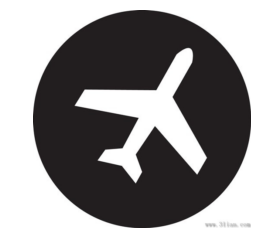

In [94]:
wordscloud(text_2)